# Import All Library

In [2]:
# Menambahkan path untuk mengimpor modul dari direktori yang lebih tinggi
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))  # Menambahkan path ke direktori yang lebih tinggi

# Mengimpor pustaka yang dibutuhkan
import pickle  # Untuk menyimpan dan memuat objek Python
import numpy as np  # Untuk operasi numerik dengan array
import os  # Untuk operasi terkait file dan direktori
import torch.optim  # Untuk mengimpor optimizers dari PyTorch

# Mengimpor berbagai kelas model dari modul 'model'
from model.DDQN import DDQN_Agent  # Model Double Deep Q-Network (DDQN)
from model.DoubleDQN import DoubleDQN_Agent  # Model DoubleDQN
from model.DuellingDQN import DuellingDQN_Agent  # Model DuellingDQN
from model.DuellingDoubleDQN import D3QN_Agent  # Model Duelling Double DQN (D3QN)
from model.NoisyDQN import NoisyDQN_Agent  # Model Noisy DQN
from model.NoisyDuellingDoubleDQN import NoisyD3QN_Agent  # Model Noisy Duelling Double DQN (NoisyD3QN)
from model.DQN import DQN_Agent  # Model DQN (Deep Q-Network)
from model.ActorCritic import ActorCriticAgent  # Model Actor-Critic
from model.WD3QN import WD3QN_Agent  # Model Weighted Duelling Double DQN (WD3QN)

# Mengimpor fungsi evaluasi dan pengujian dari modul 'support_class.evaluate_general'
from support_class.evaluate_general import do_eval, do_test, do_eval_ac, do_test_ac

# Mengimpor pustaka untuk visualisasi data
import matplotlib.pyplot as plt

# Menentukan perangkat yang digunakan (CPU atau GPU)
device = "cpu"  # Menetapkan 'cpu' sebagai perangkat
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Dapat mengganti ke GPU jika tersedia
# print(f"Using device: {device}")  # Mencetak perangkat yang digunakan

# Mengimpor fungsi untuk normalisasi data (z-score) dari scipy
from scipy.stats import zscore, rankdata

# Membuat fungsi normalisasi z-score kustom
def my_zscore(x):
    return zscore(x, ddof=1), np.mean(x, axis=0), np.std(x, axis=0, ddof=1)  
    # Mengembalikan nilai z-score, rata-rata, dan deviasi standar dari array x


# Parameter Settings

In [ ]:
# Set parameter pelatihan

num_epoch = 101  # Jumlah epoch pelatihan (Number of training epochs: 101 epoch)
gamma = 0.99  # Faktor diskonto (Discount factor untuk reinforcement learning, biasanya mendekati 1 untuk memberi bobot lebih pada reward jangka panjang)
beat1 = 0  # Parameter yang dapat disesuaikan 1 (Adjustable parameter 1, disetel ke 0)
beat2 = 0.6  # Parameter yang dapat disesuaikan 2 (Adjustable parameter 2, disetel ke 0.6)
beta3 = 0.3  # Parameter yang dapat disesuaikan 3 (Adjustable parameter 3, disetel ke 0.3)

ncv = 5  # Jumlah iterasi cross-validation (Number of cross-validation runs, setiap iterasi menggunakan 80% data untuk pelatihan dan 20% untuk pengujian)
nra = 5  # Parameter yang dapat disesuaikan nra (Adjustable parameter nra, disetel ke 5)
lr = 1e-5  # Laju pembelajaran (Learning rate untuk optimisasi, nilai sangat kecil yaitu 1e-5)
reward_value = 24  # Nilai reward (Set nilai reward untuk perhitungan dalam reinforcement learning)
beta = [beat1, beat2, beta3]  # Daftar parameter yang dapat disesuaikan (List of adjustable parameters)


In [ ]:
# Menentukan tipe MIMIC dataset (3 untuk MIMIC-III, 4 untuk MIMIC-IV)
mimic_type = 4

# Tentukan path untuk menyimpan hasil (result)
save_path = f'../../result/mimic{mimic_type}/general'
# Membuat direktori jika belum ada
os.makedirs(save_path, exist_ok=True)

# Memuat data berdasarkan tipe MIMIC yang dipilih
if mimic_type == 3:
    print('####  LOAD DATA MIMIC-III ####')
    # Membaca file pickle yang berisi data MIMIC-III
    with open('../../data/step_4_start.pkl', 'rb') as file:
        MIMICtable = pickle.load(file)

    # Memuat data numpy untuk pelatihan, validasi, dan pengujian untuk MIMIC-III
    train = np.load('../../data/train.npy')
    validat = np.load('../../data/validation.npy')
    test = np.load('../../data/test.npy')
else:
    print('####  LOAD DATA MIMIC-IV ####')
    # Membaca file pickle yang berisi data MIMIC-IV
    with open('../../data/step_4_start_mimiciv.pkl', 'rb') as file:
        MIMICtable = pickle.load(file)

    # Memuat data numpy untuk pelatihan, validasi, dan pengujian untuk MIMIC-IV
    train = np.load('../../data/train_mimiciv.npy')
    validat = np.load('../../data/validation_mimiciv.npy')
    test = np.load('../../data/test_mimiciv.npy')

# Menentukan nama kolom untuk ICU stay id sesuai tipe MIMIC
if mimic_type == 3:
    icustayidlist = MIMICtable['icustayid']  # Menggunakan 'icustayid' untuk MIMIC-III
else:
    icustayidlist = MIMICtable['stay_id']  # Menggunakan 'stay_id' untuk MIMIC-IV

# Mengambil daftar ID stay ICU yang unik
icuuniqueids = np.unique(icustayidlist)  # List ID stay ICU unik

# Membuat salinan DataFrame MIMICtable ke dalam array NumPy
reformat5 = MIMICtable.values.copy()

# Mengambil daftar ID stay ICU yang unik dari MIMIC
icuuniqueids = np.unique(icustayidlist)

# Membuat salinan dari DataFrame MIMICtable ke dalam array NumPy untuk pemrosesan lebih lanjut
reformat5 = MIMICtable.values.copy()

# Menampilkan pesan untuk menunjukkan status pemrosesan
print('####  生成状态  ####')

# -----------------------筛选后的特征=37个--------------------------------

# Menentukan fitur yang akan diproses berdasarkan jenisnya:
colbin = ['max_dose_vaso']  # Fitur biner, hanya satu fitur (max_dose_vaso)
colnorm = ['SOFA', 'age', 'GCS', 'Weight_kg', 'Platelets_count', 'PT', 'PTT', 'Albumin', 'WBC_count', 
           'Arterial_lactate', 'Creatinine', 'HCO3', 'Ionised_Ca', 'Arterial_BE', 'Arterial_pH', 
           'Sodium', 'SGPT', 'Shock_Index', 'cumulated_balance', 'Chloride', 'Hb', 'paCO2', 
           'CO2_mEqL', 'PaO2_FiO2', 'Calcium', 'paO2', 'RR']  # Fitur numerik
collog = ['BUN', 'INR', 'SGOT', 'Total_bili', 'output_4hourly', 'input_total', 'SpO2', 'output_total', 'elixhauser']  # Fitur logaritmik

# Menentukan indeks kolom untuk fitur-fitur yang dipilih
colbin = np.where(np.isin(MIMICtable.columns, colbin))[0]
colnorm = np.where(np.isin(MIMICtable.columns, colnorm))[0]
collog = np.where(np.isin(MIMICtable.columns, collog))[0]

# Melakukan normalisasi dan transformasi pada data:
# - Mengurangi 0.5 pada fitur biner (karena hanya ada dua nilai, 0 dan 1).
# - Menggunakan z-score untuk fitur numerik (colnorm).
# - Menggunakan z-score untuk logaritma fitur (collog), dengan penambahan 0.1 untuk menghindari log(0).
scaleMIMIC = np.concatenate([reformat5[:, colbin] - 0.5, 
                             zscore(reformat5[:, colnorm], ddof=1),
                             zscore(np.log(0.1 + reformat5[:, collog]), ddof=1)], axis=1)

# Membagi data untuk validasi, pelatihan, dan pengujian sesuai dengan indeks yang telah dipilih:
Xvalidat = scaleMIMIC[validat, :]  # Data validasi
blocsvalidat = reformat5[validat, 0]  # ID stay ICU untuk validasi
ptidvalidat = reformat5[validat, 1]  # ID pasien untuk validasi

Xtrain = scaleMIMIC[train, :]  # Data pelatihan
Xtest = scaleMIMIC[test, :]  # Data pengujian
blocstrain = reformat5[train, 0]  # ID stay ICU untuk pelatihan
bloctest = reformat5[test, 0]  # ID stay ICU untuk pengujian
ptidtrain = reformat5[train, 1]  # ID pasien untuk pelatihan
ptidtest = reformat5[test, 1]  # ID pasien untuk pengujian


# Menyimpan data pelatihan untuk RNN (Recurrent Neural Network)
RNNstate = Xtrain  # ***

# nra adalah jumlah aksi yang mungkin (misalnya, 5 aksi untuk IV fluid dan 5 aksi untuk vasopressor)
nact = nra * nra  # 5*5=25 kemungkinan aksi

# Menentukan indeks kolom untuk fitur input IV fluid dan dosis vasopressor
iol = MIMICtable.columns.get_loc('input_4hourly')  # Kolom input IV fluid
vcl = MIMICtable.columns.get_loc('max_dose_vaso')  # Kolom dosis maksimum vasopressor

# Menyalin data IV fluid dan menghitung peringkatnya (dalam hal ini, tidak termasuk nilai 0)
a = reformat5[:, iol].copy()  # IV fluid
a = rankdata(a[a > 0]) / a[a > 0].shape[0]  # Mengabaikan fluid nol (akan menjadi aksi 1)

# Mengonversi volume IV fluid ke dalam 4 aksi yang mungkin (menggunakan pembulatan)
iof = np.floor((a + 0.2499999999) * 4)  # Konversi volume IV fluid menjadi 4 aksi
a = reformat5[:, iol].copy()  # Menyalin kembali data IV fluid
a = np.where(a > 0)[0]  # Menentukan lokasi nilai fluid yang lebih besar dari 0
io = np.ones((reformat5.shape[0], 1))  # Membuat array berisi 1
io[a] = (iof + 1).reshape(-1, 1)  # Menyimpan aksi aktual pada lokasi fluid > 0
io = io.ravel()  # Meratakan array dari 2D menjadi 1D

# Menghitung peringkat untuk dosis vasopressor
vc = reformat5[:, vcl].copy()
vcr = rankdata(vc[vc != 0]) / vc[vc != 0].size  # Menghitung peringkat untuk dosis vasopressor (tidak termasuk nol)
vcr = np.floor((vcr + 0.249999999999) * 4)  # Mengonversi menjadi 4 kategori
vcr[vcr == 0] = 1  # Mengganti nilai 0 dengan 1
vc[vc != 0] = vcr + 1  # Mengupdate nilai untuk dosis vasopressor yang tidak nol
vc[vc == 0] = 1  # Nilai nol diganti dengan 1

# Menghitung median dosis IV fluid dan vasopressor untuk setiap kategori aksi
ma1 = np.array(
    [np.median(reformat5[io == 1, iol]), np.median(reformat5[io == 2, iol]), np.median(reformat5[io == 3, iol]),
        np.median(reformat5[io == 4, iol]), np.median(reformat5[io == 5, iol])])  # Median dosis IV fluid untuk semua kategori

ma2 = np.array(
    [np.median(reformat5[vc == 1, vcl]), np.median(reformat5[vc == 2, vcl]), np.median(reformat5[vc == 3, vcl]),
        np.median(reformat5[vc == 4, vcl]), np.median(reformat5[vc == 5, vcl])])  # Median dosis vasopressor untuk semua kategori

# Menyusun tindakan dalam format yang diinginkan
med = np.concatenate([io.reshape(-1, 1), vc.reshape(-1, 1)], axis=1)  # Menggabungkan aksi IV fluid dan vasopressor
uniqueValues, actionbloc = np.unique(med, axis=0, return_inverse=True)  # Mendapatkan nilai unik dan blok tindakan

# Membagi blok tindakan untuk data pelatihan, validasi, dan pengujian
actionbloctrain = actionbloc[train]  # Blok tindakan untuk data pelatihan
actionblocvalidat = actionbloc[validat]  # Blok tindakan untuk data validasi
actionbloctest = actionbloc[test]  # Blok tindakan untuk data pengujian

# Mendapatkan nilai median dosis untuk setiap tindakan berdasarkan blok unik
ma2Values = ma2[uniqueValues[:, 1].astype('int64') - 1].reshape(-1, 1)  # Median dosis vasopressor untuk setiap aksi
ma1Values = ma1[uniqueValues[:, 0].astype('int64') - 1].reshape(-1, 1)  # Median dosis IV fluid untuk setiap aksi

# Menggabungkan nilai median dosis untuk setiap aksi
uniqueValuesdose = np.concatenate([ma2Values, ma1Values], axis=1)  # Gabungkan dosis median IV fluid dan vasopressor

# Mendapatkan outcome (misalnya 9, yang merupakan indeks untuk nilai tertentu dalam data)
outcome = 9
Y90 = reformat5[train, outcome]  # Ambil outcome untuk data pelatihan

# Menyiapkan nilai reward
r = np.array([reward_value, -reward_value]).reshape(1, -1)  # Membuat dua nilai reward, positif dan negatif
r2 = r * (2 * (1 - Y90.reshape(-1, 1)) - 1)  # Fungsi reward berdasarkan outcome (apakah outcome positif atau negatif)

# Persiapan untuk reward function
SOFA = reformat5[train, 57]  # Ambil SOFA score (indeks 57 pada data)
R3 = r2[:, 0]  # Ambil reward yang dihitung sebelumnya (untuk outcome negatif)
R4 = (R3 + reward_value) / (2 * reward_value)  # Normalisasi reward ke dalam rentang [0, 1]

# Inisialisasi variabel untuk perhitungan lanjutan
c = 0  # variabel untuk dihitung (nilai tidak jelas di sini)
bloc_max = max(blocstrain)  # Mendapatkan nilai maksimum dari blok pelatihan

# Mendapatkan ukuran state (jumlah fitur dalam RNNstate)
statesize = int(RNNstate.shape[1])

# Inisialisasi array untuk menyimpan data trajectory (perjalanan model)
# Ukuran array disesuaikan dengan 1.2 kali jumlah data RNNstate (untuk menampung data lebih banyak saat perlu)
states = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), statesize))  # Menyimpan state (fitur)
actions = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1), dtype=int)  # Menyimpan tindakan yang diambil
next_actions = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1), dtype=int)  # Menyimpan tindakan berikutnya
rewards = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))  # Menyimpan reward yang diterima
next_states = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), statesize))  # Menyimpan state berikutnya
done_flags = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))  # Menyimpan flag selesai (terminal state)
bloc_num = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))  # Menyimpan nomor blok (untuk identifikasi)
blocnum1 = 1  # Inisialisasi nomor blok pertama (dapat digunakan untuk penanda dalam pelatihan)


# Inisialisasi bloc_num_reward untuk melacak reward selama trajektori
bloc_num_reward = 0

# Loop untuk setiap baris (trajektori pasien) kecuali baris terakhir
for i in range(RNNstate.shape[0] - 1):
    # Menetapkan state saat ini ke array trajektori
    states[c] = RNNstate[i, :]
    
    # Menetapkan action saat ini ke array trajektori
    actions[c] = actionbloctrain[i]
    
    # Melacak nomor bloc saat ini (ini bisa digunakan untuk pengelompokan pasien atau kategorisasi)
    bloc_num[c] = blocnum1
    
    # Jika state berikutnya menunjukkan akhir dari trajektori pasien (akhir dari jejak)
    if (blocstrain[i + 1] == 1):  
        # Menetapkan next state dan action menjadi nol (akhir dari urutan untuk pasien ini)
        next_states1 = np.zeros(statesize)  
        next_actions1 = -1  # Menandakan tidak ada aksi valid berikutnya (akhir episode)
        done_flags1 = 1  # Menandai trajektori ini selesai (episode selesai)
        
        # Meningkatkan blocnum1 untuk memulai trajektori baru untuk pasien berikutnya
        blocnum1 = blocnum1 + 1
        
        # Mereset pelacakan reward untuk pasien berikutnya
        bloc_num_reward += 1
        
        # Menghitung reward menggunakan rumus yang didasarkan pada skor SOFA (gagal organ terkait sepsis)
        reward1 = -beat1 * (SOFA[i]) + R3[i]  # Fungsi reward (sesuaikan sesuai kebutuhan)
        
        # Mereset bloc_num_reward ke nol setelah menghitung reward
        bloc_num_reward = 0
    else:
        # Untuk state yang tidak terminal, lanjutkan ke next state dan action berikutnya
        next_states1 = RNNstate[i + 1, :]
        next_actions1 = actionbloctrain[i + 1]
        done_flags1 = 0  # Trajektori ini belum selesai (masih berlanjut)
        
        # Menjaga nomor bloc saat ini untuk pasien yang sedang berlangsung
        blocnum1 = blocnum1
        
        # Menghitung reward berdasarkan perbedaan skor SOFA antara langkah-langkah berturut-turut
        reward1 = -beat2 * (SOFA[i + 1] - SOFA[i])  # Fungsi reward (sesuaikan sesuai kebutuhan)
        
        # Meningkatkan bloc_num_reward untuk melacak reward dalam urutan yang sedang berlangsung
        bloc_num_reward += 1
    
    # Menetapkan nilai yang dihitung ke array yang sesuai
    next_states[c] = next_states1
    next_actions[c] = next_actions1
    rewards[c] = reward1
    done_flags[c] = done_flags1
    
    # Meningkatkan indeks 'c' untuk melanjutkan ke posisi berikutnya dalam array trajektori
    c = c + 1

# Menetapkan state, action, dan nomor bloc terakhir ke array
states[c] = RNNstate[c, :]
actions[c] = actionbloctrain[c]
bloc_num[c] = blocnum1

# Ketika trajektori pasien berakhir (atau di akhir urutan)
next_states1 = np.zeros(statesize)  # Reset next state menjadi nol (akhir episode)
next_actions1 = -1  # Menandakan tidak ada aksi valid berikutnya
done_flags1 = 1  # Menandai trajektori selesai (selesai)
blocnum1 = blocnum1 + 1  # Meningkatkan nomor bloc untuk pasien berikutnya
bloc_num_reward += 1  # Meningkatkan pelacak reward untuk bloc saat ini

# Menghitung reward berdasarkan skor SOFA dan fungsi reward khusus
reward1 = -beat1 * (SOFA[c]) + R3[c]  # Fungsi reward khusus (sesuaikan sesuai kebutuhan)

# Mereset bloc_num_reward setelah menghitung reward
bloc_num_reward = 0

# Menyimpan next state, next action, reward, dan done flag yang telah dihitung dalam array
next_states[c] = next_states1
next_actions[c] = next_actions1
rewards[c] = reward1
done_flags[c] = done_flags1

# Melanjutkan ke indeks berikutnya (langkah trajektori berikutnya)
c = c + 1

# Setelah memproses pasien saat ini (atau urutan), perbarui nomor bloc dan hapus elemen yang berlebih
bloc_num[c] = blocnum1  # Memperbarui nomor bloc terakhir untuk pasien yang sedang berlangsung
bloc_num = bloc_num[:c, :]  # Memangkas array agar hanya mencakup entri yang sudah diproses
states = states[:c, :]  # Memangkas array states untuk menyesuaikan langkah yang diproses
next_states = next_states[:c, :]  # Memangkas array next states
actions = actions[:c, :]  # Memangkas array actions
next_actions = next_actions[:c, :]  # Memangkas array next actions
rewards = rewards[:c, :]  # Memangkas array rewards
done_flags = done_flags[:c, :]  # Memangkas array done flags

# Squeeze array untuk menghapus dimensi ekstra (memastikan array 1D ketika diperlukan)
bloc_num = np.squeeze(bloc_num)
actions = np.squeeze(actions)
rewards = np.squeeze(rewards)
done_flags = np.squeeze(done_flags)

# Mendapatkan ukuran batch berdasarkan jumlah states (baris pada array states)
batch_size = states.shape[0]

# Mengonversi array numpy ke tensor PyTorch dan mengirimnya ke perangkat (GPU atau CPU)
state = torch.FloatTensor(states).to(device)  # States sebagai tensor floating point
next_state = torch.FloatTensor(next_states).to(device)  # Next states
action = torch.LongTensor(actions).to(device)  # Actions sebagai tensor integer panjang
next_action = torch.LongTensor(next_actions).to(device)  # Next actions
reward = torch.FloatTensor(rewards).to(device)  # Rewards sebagai tensor floating point
done = torch.FloatTensor(done_flags).to(device)  # Done flags (menandakan apakah episode selesai)

# Mengonversi skor SOFA ke tensor PyTorch (ini mungkin digunakan untuk perhitungan lebih lanjut)
SOFAS = torch.LongTensor(SOFA).to(device)

# Mengemas tensor-tensor ini ke dalam batch untuk digunakan dalam model (biasanya berupa tuple input tensor)
batchs = (state, next_state, action, next_action, reward, done, bloc_num, SOFAS)

# ===================== Loop Pelatihan Model =====================
# Menyiapkan data validasi (digunakan untuk memvalidasi kinerja model selama pelatihan)
Y90_validat = reformat5[validat, outcome]  # Mengambil data outcome untuk validasi
SOFA_validat = reformat5[validat, 57]  # Mengambil skor SOFA untuk validasi


# Training Process

In [ ]:
# Menyimpan model ke path tertentu
save_model_path = save_path + "/model/"
os.makedirs(save_model_path, exist_ok=True)  # Membuat folder untuk menyimpan model jika belum ada

# Mendefinisikan berbagai jenis model DQN yang akan dilatih
models = {
    "DQN": DQN_Agent(),
    "DistDQN": DDQN_Agent(),
    "DoubleDQN": DoubleDQN_Agent(),
    "DuellingDQN": DuellingDQN_Agent(),
    "DuellingDoubleDQN": D3QN_Agent(),
    "NoisyDQN": NoisyDQN_Agent(),
    "NoisyDuellingDoubleDQN": NoisyD3QN_Agent()
}

# Membuat dictionary untuk mencatat kehilangan (loss) dan Q-values dari setiap model
record_loss_z = {model_name: [] for model_name in models.keys()}
record_phys_q = {model_name: [] for model_name in models.keys()}
record_agent_q = {model_name: [] for model_name in models.keys()}

# Mulai loop untuk setiap epoch
for epoch in range(num_epoch):
    # Loop untuk setiap model yang dilatih
    for model_name, model_list in models.items():
        print(f"============== {model_name} ==============")
        model = models[model_name]  # Mengambil model berdasarkan nama
        record = model.train(batchs, epoch)  # Melatih model dengan batch dan epoch saat ini
        record_loss_z[model_name].append(record)  # Mencatat nilai loss pada setiap epoch
        
        # Menyimpan model setiap 20 epoch
        if epoch % 20 == 0:
            torch.save({
                'actor_state_dict': model.actor.state_dict() if hasattr(model, 'actor') else None,
                'critic_state_dict': model.critic.state_dict() if hasattr(model, 'critic') else None,
                'Q_state_dict': model.Q.state_dict() if hasattr(model, 'Q') else None,
                'Q_target_state_dict': model.Q_target.state_dict() if hasattr(model, 'Q_target') else None
            }, os.path.join(save_model_path, f'{model_name}__{epoch}.pt'))  # Menyimpan model ke file .pt

        # Menghitung dan mencatat hasil loss
        record_a = np.array(record_loss_z[model_name])
        record_b = np.sum(record_a, axis=1)

        # ------------------- Evaluasi pada validasi -------------------
        # Mengambil batch validasi
        batch_s = ptidvalidat
        uids = np.unique(bloc_num)  # Mendapatkan ID unik dari setiap pasien
        batch_uids = range(1, len(batch_s))  # Membuat rentang ID untuk batch validasi
        batch_user = np.isin(bloc_num, batch_uids)  # Mengambil data yang sesuai dengan ID pasien
        state_user = state[batch_user, :]  # Mengambil state untuk pasien yang relevan
        next_state_user = next_state[batch_user, :]  # Mengambil next state untuk pasien yang relevan
        action_user = action[batch_user]  # Mengambil tindakan yang diambil oleh model
        next_action_user = next_action[batch_user]  # Mengambil tindakan selanjutnya yang diambil oleh model
        reward_user = reward[batch_user]  # Mengambil reward yang diterima
        done_user = done[batch_user]  # Menandakan apakah episode telah selesai
        sofa_user = SOFA[batch_user]  # Mengambil skor SOFA untuk evaluasi
        bloc_num_user = bloc_num[batch_user]  # Mengambil nomor blok untuk batch ini
        batch = (state_user, next_state_user, action_user, next_action_user, reward_user, done_user, bloc_num_user, sofa_user)

        # Evaluasi model dengan batch validasi
        q_output, agent_actions, phys_actions, _ = do_eval(model, batch)
        agent_actions = np.array(agent_actions, dtype=int)  # Mengkonversi tindakan model menjadi integer
        phys_actions = np.array(phys_actions, dtype=int)  # Mengkonversi tindakan dokter menjadi integer

        # Menghitung Q-value untuk tindakan yang diambil oleh model dan dokter
        agent_q = q_output[np.arange(len(q_output)), agent_actions].detach().numpy()  # Q-value model
        phys_q = q_output[np.arange(len(q_output)), phys_actions].detach().numpy()  # Q-value dokter

        # Mencatat rata-rata Q-value untuk model dan dokter
        record_phys_q[model_name].append(np.mean(phys_q))  # Rata-rata Q-value dokter
        record_agent_q[model_name].append(np.mean(agent_q))  # Rata-rata Q-value model

        # Menampilkan hasil Q-value rata-rata
        print('mean agent Q:', np.mean(agent_q))
        print('mean phys Q:', np.mean(phys_q))

        # Menampilkan tindakan yang diambil oleh model dan dokter
        print('agent_actions：', agent_actions)
        print('phys_actions：', phys_actions)


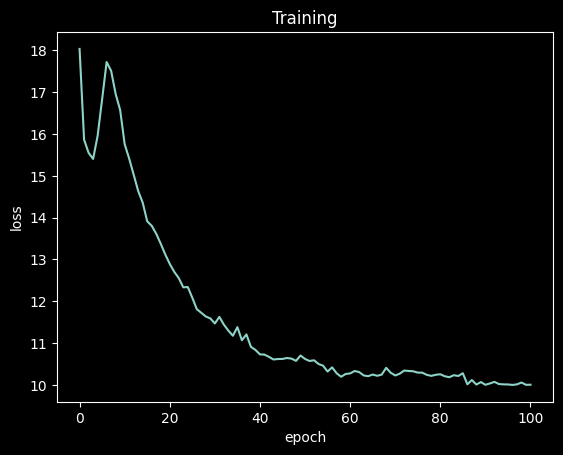

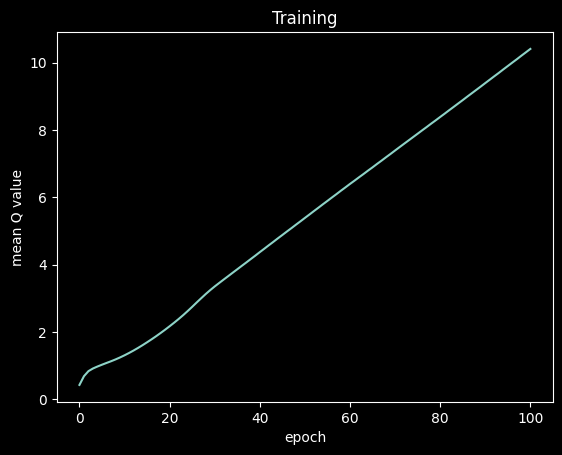

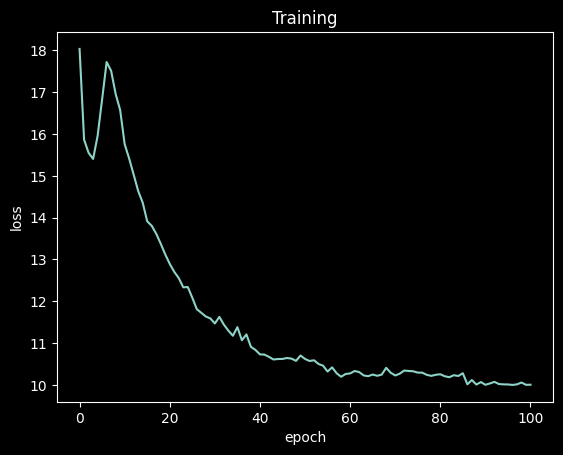

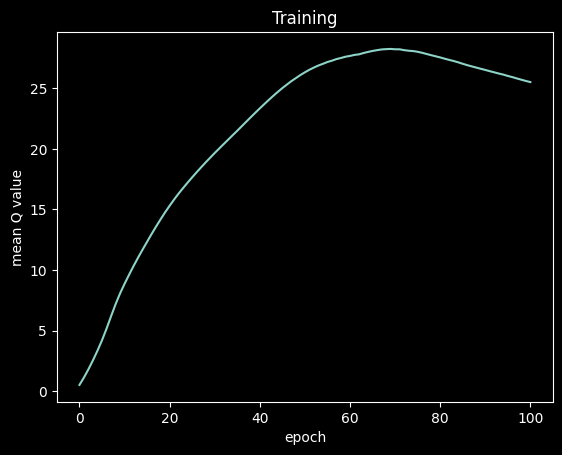

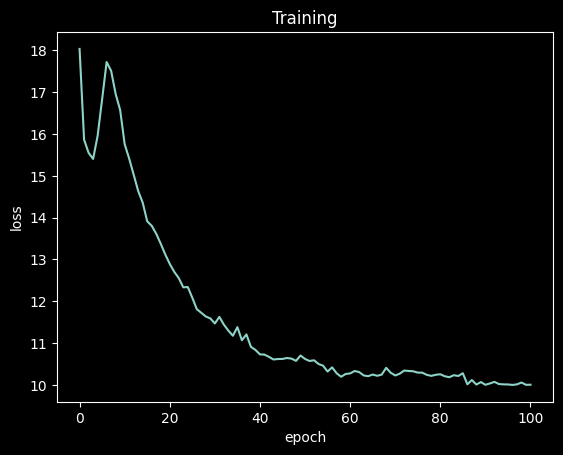

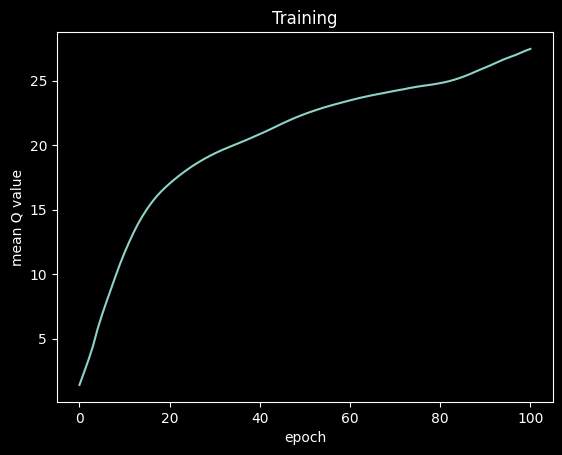

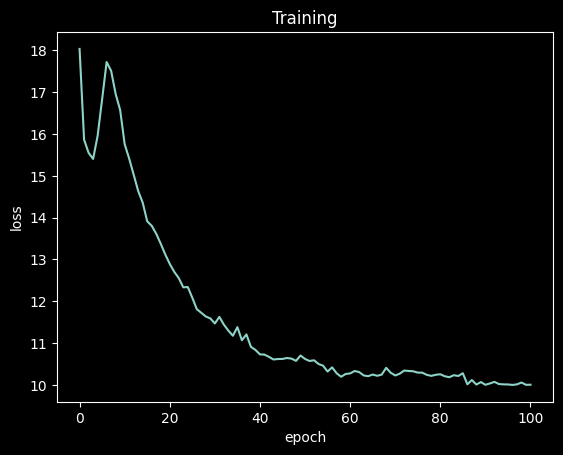

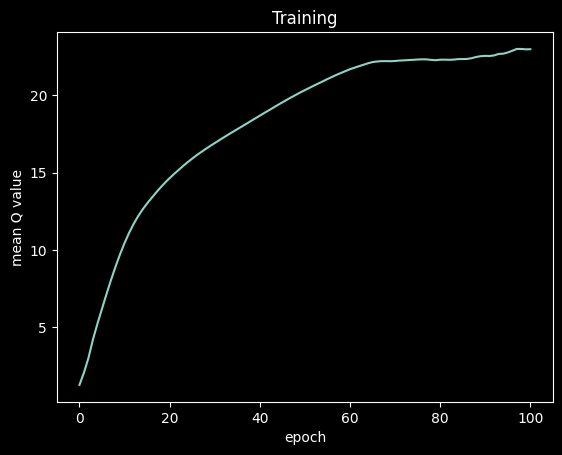

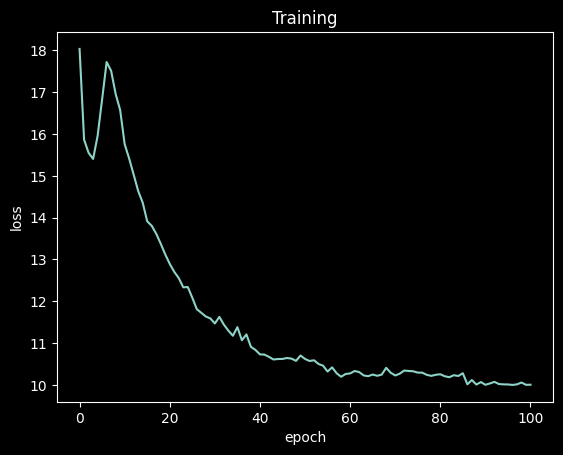

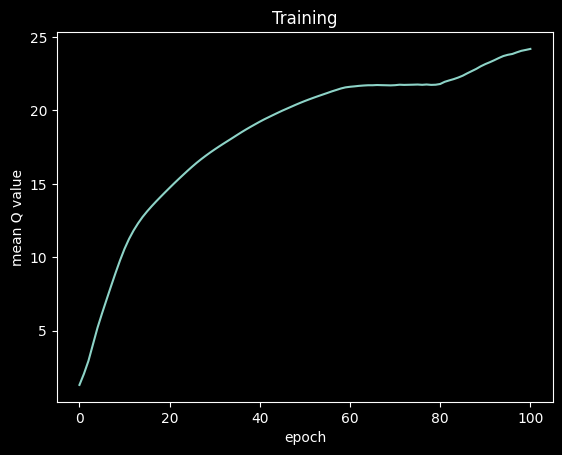

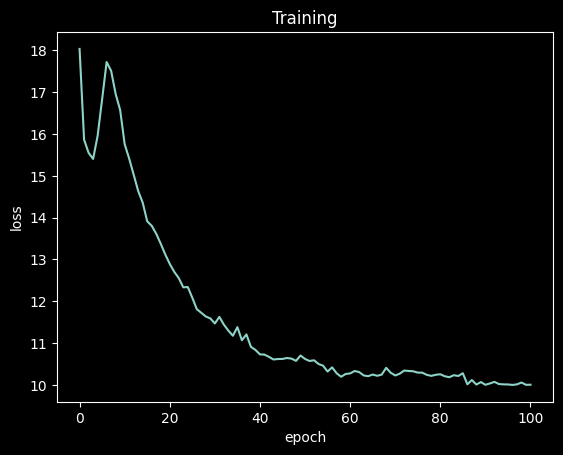

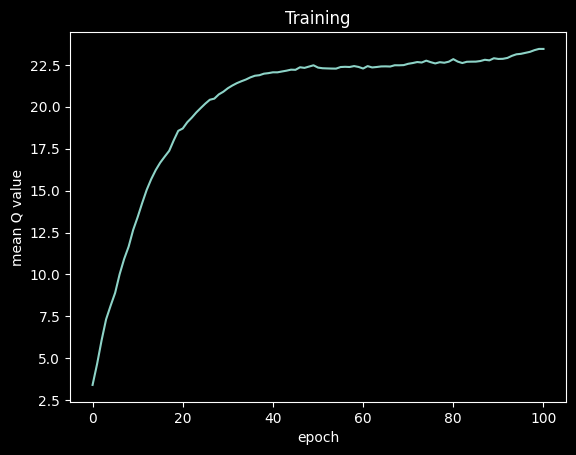

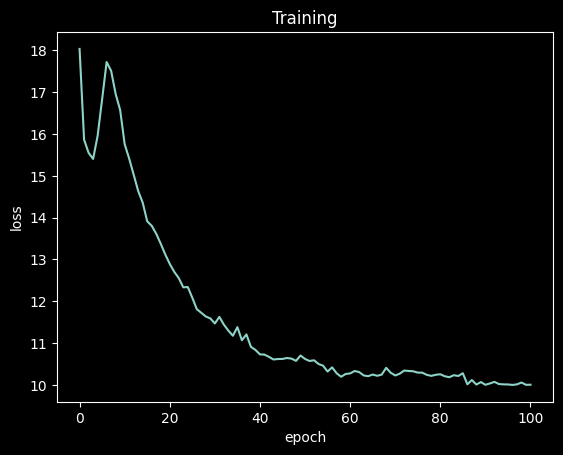

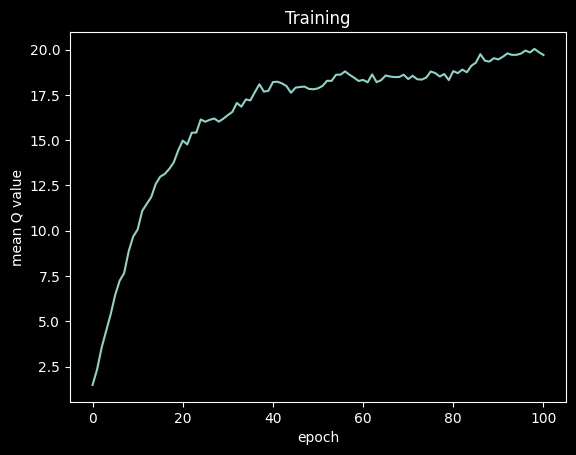

In [4]:
# =========== Bagian untuk membuat grafik =============================
for model_name, model_list in models.items():
    # Membuat daftar x (epoch) untuk plot grafik loss
    x_length_list = list(range(len(record_b)))
    
    # Membuat grafik untuk loss (kerugian)
    plt.figure()  # Membuat grafik baru
    plt.title('Training')  # Memberi judul grafik
    plt.xlabel("epoch")  # Menambahkan label untuk sumbu x
    plt.ylabel("loss")  # Menambahkan label untuk sumbu y
    plt.plot(x_length_list, record_b)  # Plot grafik loss
    np.save(f'{save_path}/loss.npy', record_b)  # Menyimpan data loss dalam file (loss.npy)
    
    # Membuat grafik untuk nilai rata-rata Q (mean Q value) agent
    agent_length_list = list(range(len(record_agent_q[model_name])))  # Daftar epoch untuk grafik Q agent
    plt.figure()  # Membuat grafik baru
    plt.title('Training')  # Memberi judul grafik
    plt.xlabel("epoch")  # Menambahkan label untuk sumbu x
    plt.ylabel("mean Q value")  # Menambahkan label untuk sumbu y
    plt.plot(agent_length_list, record_agent_q[model_name], label='record_agent_q ')  # Plot nilai Q agent
    np.save(f'{save_path}/mean_agent_q.npy', record_agent_q[model_name])  # Menyimpan data mean agent Q dalam file (mean_agent_q.npy)
    
    # Membuat grafik untuk nilai rata-rata Q (mean Q value) dokter fisik
    phys_length_list = list(range(len(record_phys_q)))  # Daftar epoch untuk grafik Q dokter fisik
    np.save(f'{save_path}/mean_phys_q.npy', record_phys_q[model_name])  # Menyimpan data mean phys Q dalam file (mean_phys_q.npy)


In [ ]:
# Memilih algoritma terbaik menggunakan validasi
for model_name, model_list in models.items():
    # Menentukan path untuk menyimpan hasil model
    save_path_model = save_path + f"/{model_name}"
    os.makedirs(save_path_model, exist_ok=True)  # Membuat folder untuk setiap model jika belum ada

    # Melakukan pengujian (test) pada model menggunakan data validasi
    do_test(save_path_model, models[model_name], Xvalidat, actionblocvalidat, blocsvalidat, Y90_validat, SOFA_validat, reward_value, beta)
